In [1]:
import numpy as np
import math
import torch
from torch import nn
from torch import functional as F
import scipy.stats as stats
import matplotlib
import matplotlib.pyplot as plt
from livelossplot import PlotLosses
from Inference.Variational import MeanFieldVariationalDistribution
from Inference.VariationalBoosting import MeanFieldVariationalMixtureDistribution
from Tools.NNtools import *

In [2]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda', index=0)

In [3]:
# load data and make it in proper shape
data = torch.load('data/foong_data.pt')
x_data = data[0].to(device)
y_data = data[1].to(device)
y_data = y_data.unsqueeze(-1)

In [4]:
model = nn.Sequential( nn.Linear(1, 20),
                       nn.Tanh(), 
                       nn.Linear(20, 1),
                     ).to(device)

In [5]:
param_count = get_param(model).shape[0]

In [6]:
flip_parameters_to_tensors(model)

In [7]:
prior = MeanFieldVariationalDistribution(param_count, sigma=1.0, device=device)
prior.mu.requires_grad = False
prior.rho.requires_grad = False

In [8]:
def logprior(x):
    return prior.log_prob(x)

In [9]:
def loglikelihood(theta, model, x, y, sigma_noise):
    def _log_norm(x, mu, std):
        return -0.5 * torch.log(2*np.pi*std**2) -(0.5 * (1/(std**2))* (x-mu)**2)
    #set_param(model, theta)
    set_all_parameters(model, theta)
    y_pred = model(x)
    L = _log_norm(y_pred, y, torch.tensor([sigma_noise],device=device))
    return torch.sum(L).unsqueeze(-1)

In [10]:
def logposterior(theta, model, x, y, sigma_noise):
    return logprior(theta) + loglikelihood(theta, model, x, y, sigma_noise)

In [104]:
def show_variational_posterior_predictive(q):
    x_test = torch.linspace(-2.0, 2.0).unsqueeze(1).to(device)
    # Sampling the distribution over Neural Networks 1000 times, and plotting with transparency to make it appear as a smooth distribution
    fig, ax = plt.subplots()
    fig.set_size_inches(11.7, 8.27)
    plt.xlim(-2, 2) 
    plt.ylim(-4, 4) 
    plt.scatter(x_data.cpu(), y_data.cpu())
    for _ in range(1000):
        z = q.sample()
        set_all_parameters(model, z)
        y_test = model(x_test)

        plt.plot(x_test.detach().cpu().numpy(), y_test.squeeze(0).detach().cpu().numpy(), alpha=0.05, linewidth=1, color='lightblue')

In [66]:
def MAP():
    theta = torch.nn.Parameter( prior.sample(), requires_grad=True)

    optimizer = torch.optim.Adam([theta], lr=0.1)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=5, factor=0.8)

    for t in range(10000):
        optimizer.zero_grad()

        L = -torch.mean(logposterior(theta, model, x_data, y_data, sigma_noise=0.1))
        L.backward()

        learning_rate = optimizer.param_groups[0]['lr']

        scheduler.step(L.detach().clone().cpu().numpy())
        optimizer.step()

        if learning_rate < 0.001:
            break
    return theta.detach().clone()

In [54]:
theta = MAP()

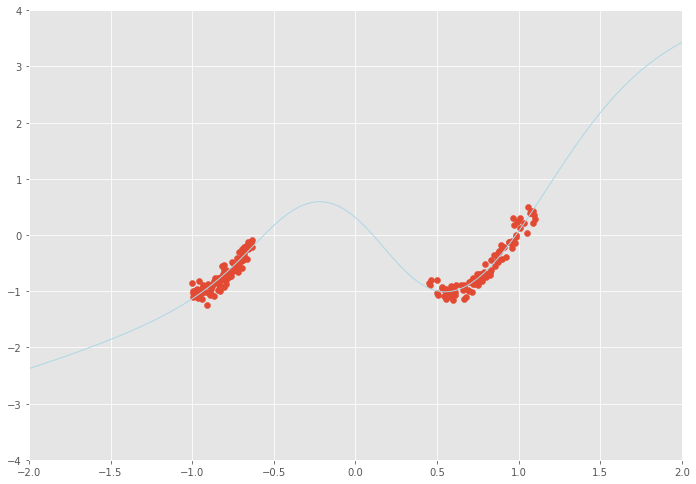

In [55]:
x_test = torch.linspace(-2.0, 2.0).unsqueeze(1).to(device)
# Sampling the distribution over Neural Networks 1000 times, and plotting with transparency to make it appear as a smooth distribution
fig, ax = plt.subplots()
fig.set_size_inches(11.7, 8.27)
plt.xlim(-2, 2) 
plt.ylim(-4, 4) 
plt.scatter(x_data.cpu(), y_data.cpu())

set_all_parameters(model, theta)
y_test = model(x_test)

plt.plot(x_test.detach().cpu().numpy(), y_test.squeeze(0).detach().cpu().numpy(), alpha=1.0, linewidth=1, color='lightblue')

In [81]:
def Boost(qC, n_samples_ELBO):
    qC.requires_grad_(False)
    for c in qC.components:
        c.mu.detach_()
        c.rho.detach_()
        
    q_new = MeanFieldVariationalDistribution(param_count, sigma=0.1, device=device)
    unbounded_prop_new = torch.tensor(2.0, device=device).requires_grad_(True)

    #q_new.mu = nn.Parameter(prior.sample()[0,:].detach().clone().to(device), requires_grad=True) 
    theta = MAP()
    q_new.mu = nn.Parameter(theta.squeeze(0).to(device), requires_grad=True) 

    q_new.rho.requires_grad = True
    q_new.mu.requires_grad = False
    
    optimizer = torch.optim.Adam(list(q_new.parameters())+[unbounded_prop_new], lr=0.1)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=50, factor=0.5)

    %matplotlib inline
    liveloss = PlotLosses()
    for t in range(1000):
        logs = {}
        optimizer.zero_grad()

        Ln = []
        for j in range(n_samples_ELBO):
            Xc = qC.sample(1)
            Xnew = q_new.sample(1)
            prop_new = torch.sigmoid(unbounded_prop_new)

            v = -(1-prop_new)*torch.mean(logposterior(Xc, model, x_data, y_data, sigma_noise=0.1) - qC.log_prob_augmented(Xc, q_new, unbounded_prop_new)) - \
            prop_new*torch.mean(logposterior(Xnew, model, x_data, y_data, sigma_noise=0.1) - qC.log_prob_augmented(Xnew, q_new, unbounded_prop_new))

            Ln.append(v)
            
        L = torch.stack(Ln).mean()
        L.backward()

        learning_rate = optimizer.param_groups[0]['lr']

        scheduler.step(L.detach().clone().cpu().numpy())
        logs['ELBO'] = L.detach().clone().cpu().numpy()
        logs['learning rate'] = learning_rate
        liveloss.update(logs)

        if t % 10 == 0:
            liveloss.draw()

        optimizer.step()

        if learning_rate < 0.001:
            break

    components = qC.components + [q_new]
    proportions = torch.cat([(1-torch.sigmoid(unbounded_prop_new))*qC.proportions, torch.tensor([torch.sigmoid(unbounded_prop_new)],device=device)]).detach()
    qC_new = MeanFieldVariationalMixtureDistribution(proportions, components, device=device)
    
    return qC_new

# Variational Distribution #

In [67]:
q = MeanFieldVariationalDistribution(param_count, sigma=0.01, device=device)
#q.mu = nn.Parameter(prior.sample()[0,:].detach().clone().to(device), requires_grad=True) 
theta = MAP()
q.mu = nn.Parameter(theta.squeeze(0).to(device), requires_grad=True) 

q.rho.requires_grad = True
q.mu.requires_grad = True

In [68]:
q.mu.detach_().requires_grad_(False)
q.rho.detach_().requires_grad_(True);

In [69]:
n_samples_ELBO = 5

In [70]:
optimizer = torch.optim.Adam(q.parameters(), lr=0.1)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=50, factor=0.5)

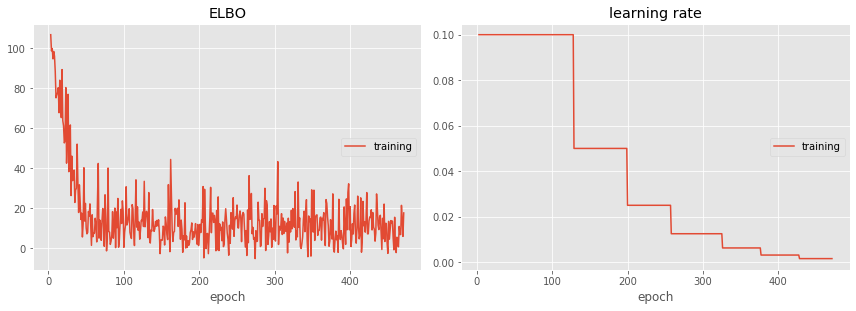

ELBO:
training   (min:   -5.414, max:  112.406, cur:   17.489)

learning rate:
training   (min:    0.002, max:    0.100, cur:    0.002)


In [71]:
%matplotlib inline
liveloss = PlotLosses()
for t in range(10000):
    logs = {}
    optimizer.zero_grad()

    Ln = []
    for j in range(n_samples_ELBO):
        z = q.sample(1)
        LQ = q.log_prob(z)
        LP = logposterior(z, model, x_data, y_data, sigma_noise=0.1)
        Ln.append(LQ - LP)

    L = torch.stack(Ln).mean()
    L.backward()
    
    learning_rate = optimizer.param_groups[0]['lr']
    
    scheduler.step(L.detach().clone().cpu().numpy())
    logs['ELBO'] = L.detach().clone().cpu().numpy()
    logs['learning rate'] = learning_rate
    liveloss.update(logs)
    
    if t % 10 == 0:
        liveloss.draw()

    optimizer.step()
    
    if learning_rate < 0.001:
        break

In [72]:
components = [q]
proportions = torch.tensor([1.0], device=device)
qC = MeanFieldVariationalMixtureDistribution(proportions, components, device=device)

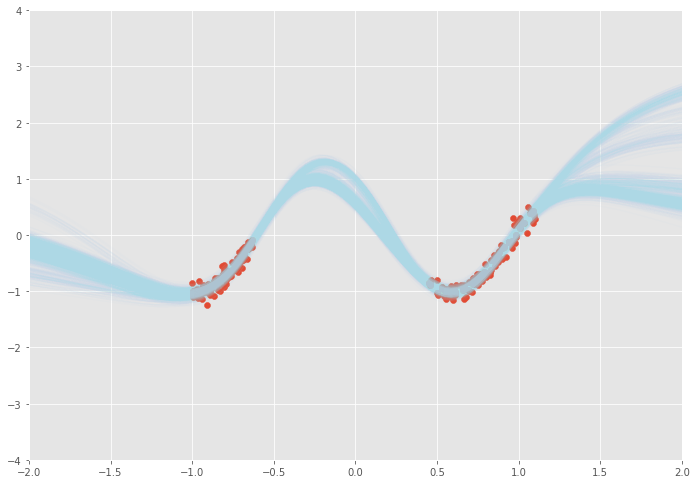

In [96]:
# Sampling the distribution over Neural Networks 1000 times, and plotting with transparency to make it appear as a smooth distribution
fig, ax = plt.subplots()
fig.set_size_inches(11.7, 8.27)
plt.xlim(-2, 2) 
plt.ylim(-4, 4) 
plt.scatter(x_data.cpu(), y_data.cpu())
for _ in range(1000):
    z = qC.sample()
    set_all_parameters(model, z)
    y_test = model(x_test)

    plt.plot(x_test.detach().cpu().numpy(), y_test.squeeze(0).detach().cpu().numpy(), alpha=0.05, linewidth=1, color='lightblue')

In [97]:
qC.proportions

tensor([0.1851, 0.0304, 0.0914, 0.4106, 0.0294, 0.0604, 0.0647, 0.1280],
       device='cuda:0')

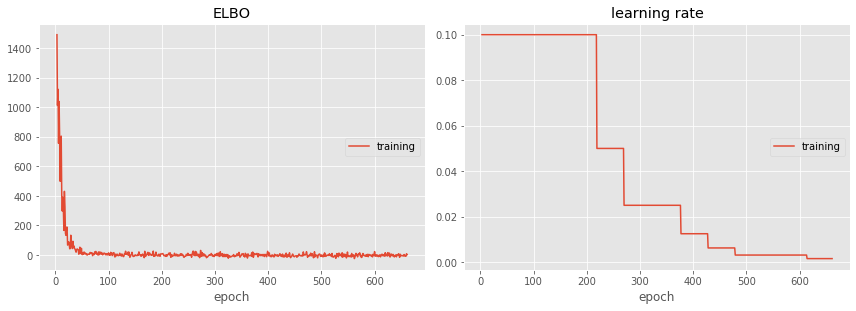

ELBO:
training   (min:  -23.897, max: 1668.025, cur:    2.592)

learning rate:
training   (min:    0.002, max:    0.100, cur:    0.002)


In [91]:
qC = Boost(qC, 10)

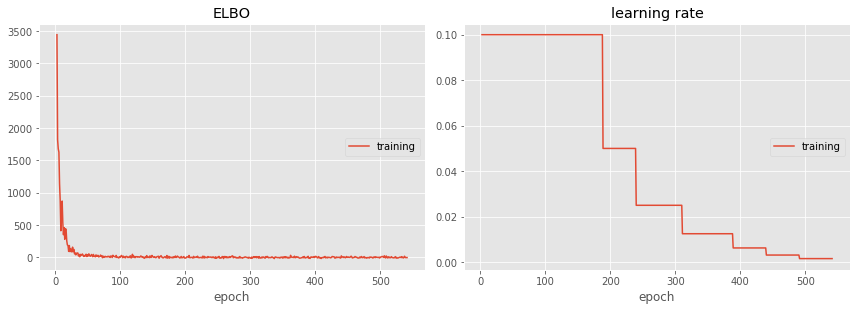

ELBO:
training   (min:  -18.543, max: 3618.361, cur:   -2.275)

learning rate:
training   (min:    0.002, max:    0.100, cur:    0.002)


In [92]:
qC = Boost(qC, 10)

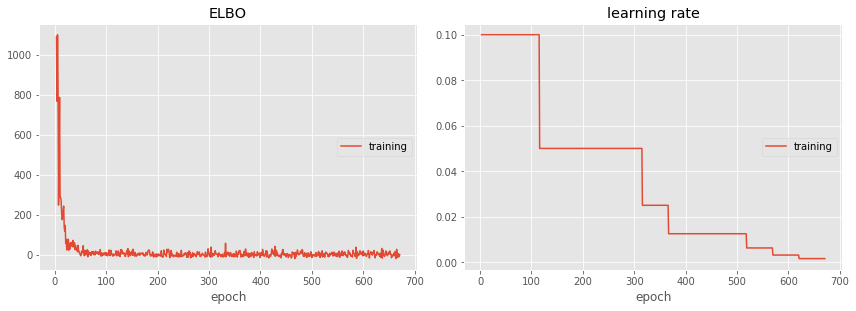

ELBO:
training   (min:  -19.922, max: 1985.054, cur:   -0.847)

learning rate:
training   (min:    0.002, max:    0.100, cur:    0.002)


In [93]:
qC = Boost(qC, 10)

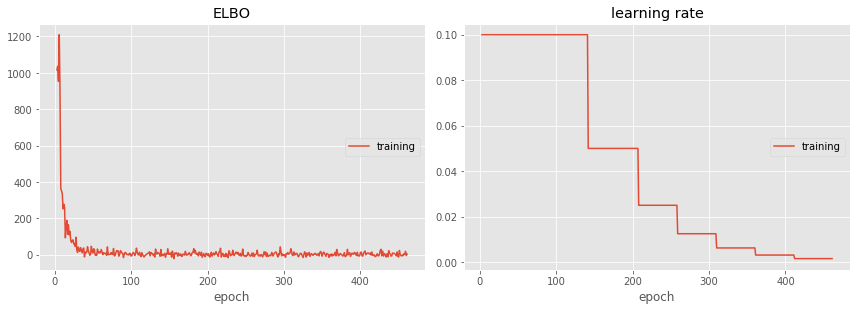

ELBO:
training   (min:  -21.187, max: 1257.743, cur:    3.881)

learning rate:
training   (min:    0.002, max:    0.100, cur:    0.002)


In [94]:
qC = Boost(qC, 10)

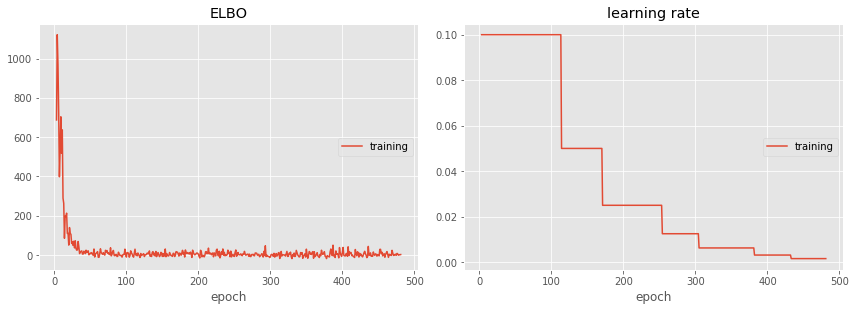

ELBO:
training   (min:  -19.050, max: 1306.146, cur:    1.679)

learning rate:
training   (min:    0.002, max:    0.100, cur:    0.002)


In [98]:
qC = Boost(qC, 10)

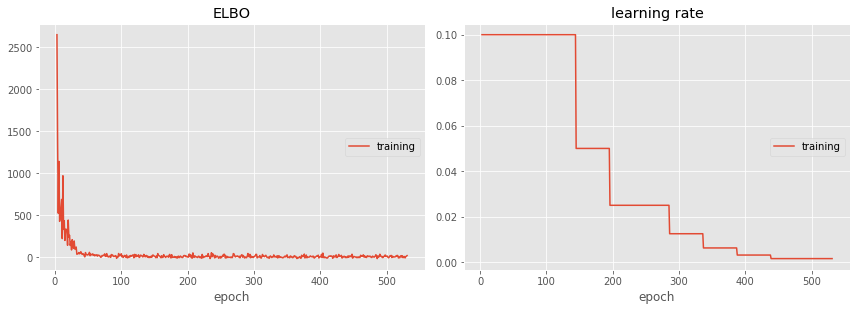

ELBO:
training   (min:  -18.601, max: 2660.524, cur:   16.909)

learning rate:
training   (min:    0.002, max:    0.100, cur:    0.002)


In [99]:
qC = Boost(qC, 10)

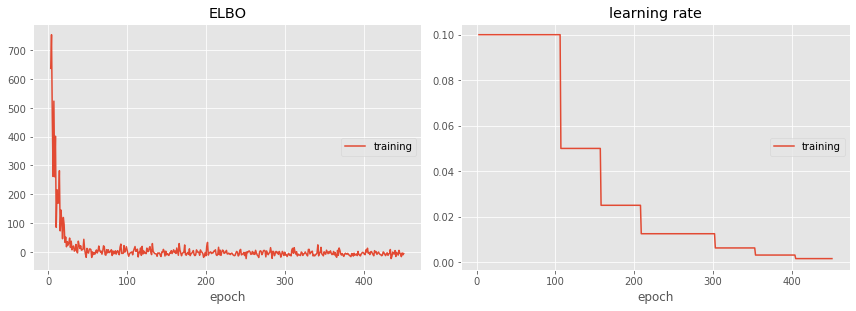

ELBO:
training   (min:  -23.623, max: 1183.185, cur:   -5.906)

learning rate:
training   (min:    0.002, max:    0.100, cur:    0.002)


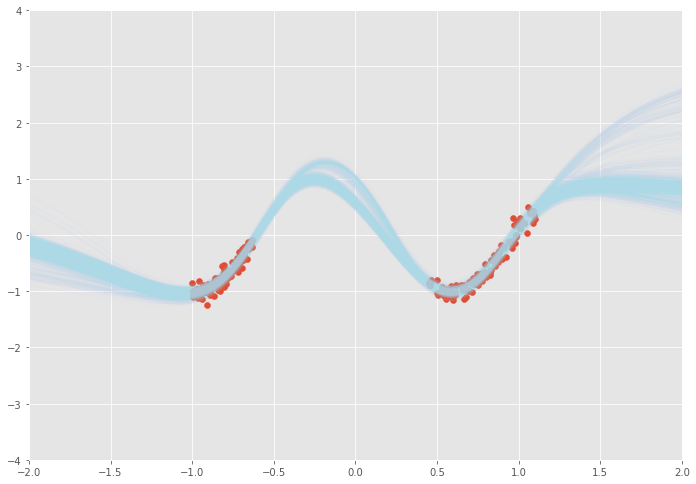

In [105]:
qC = Boost(qC, 10)
show_variational_posterior_predictive(qC)

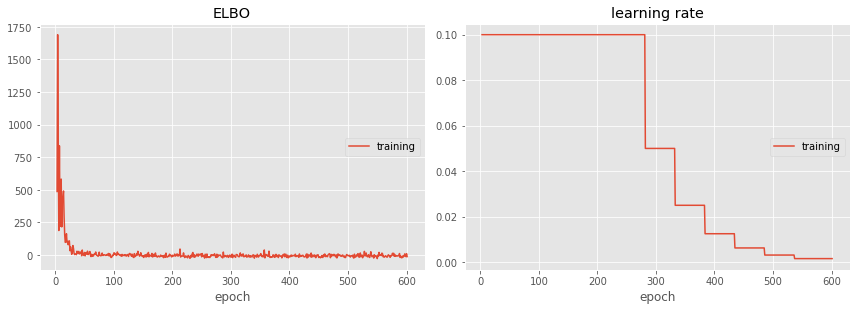

ELBO:
training   (min:  -27.135, max: 1690.243, cur:  -11.689)

learning rate:
training   (min:    0.002, max:    0.100, cur:    0.002)


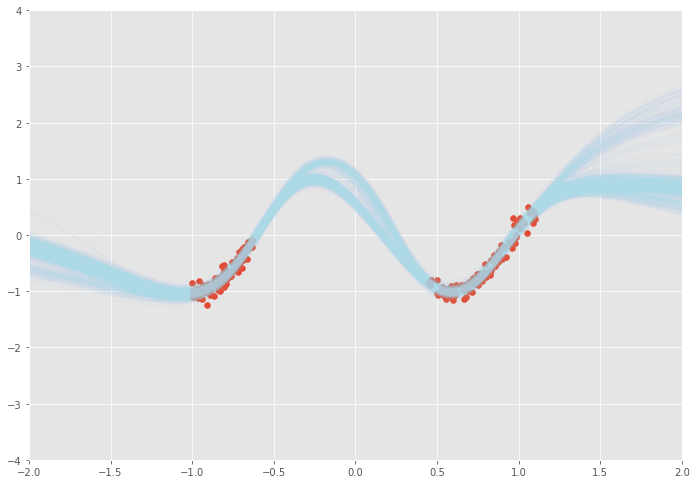

In [106]:
qC = Boost(qC, 10)
show_variational_posterior_predictive(qC)

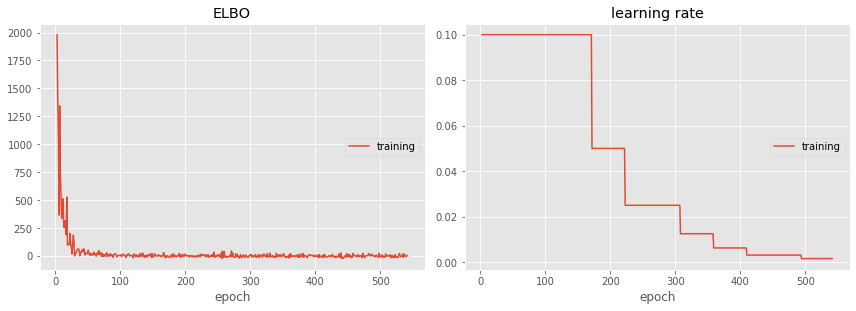

ELBO:
training   (min:  -26.029, max: 2828.440, cur:    2.082)

learning rate:
training   (min:    0.002, max:    0.100, cur:    0.002)


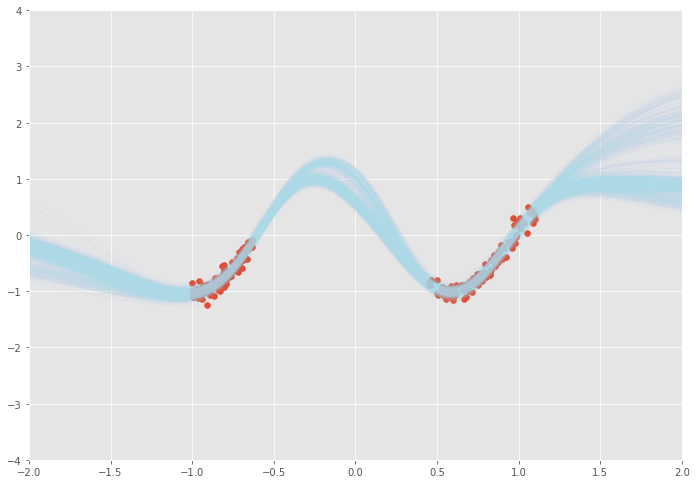

In [107]:
qC = Boost(qC, 10)
show_variational_posterior_predictive(qC)

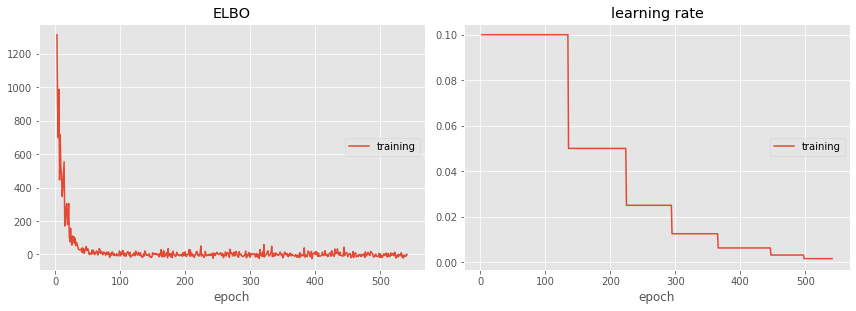

ELBO:
training   (min:  -24.653, max: 2794.361, cur:   -1.234)

learning rate:
training   (min:    0.002, max:    0.100, cur:    0.002)


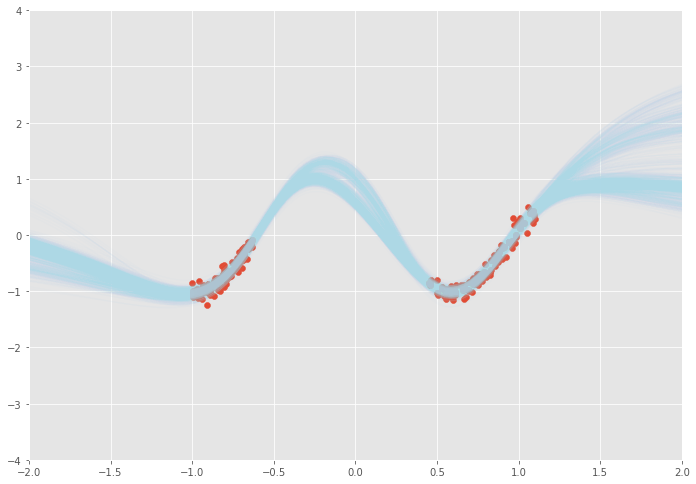

In [108]:
qC = Boost(qC, 10)
show_variational_posterior_predictive(qC)

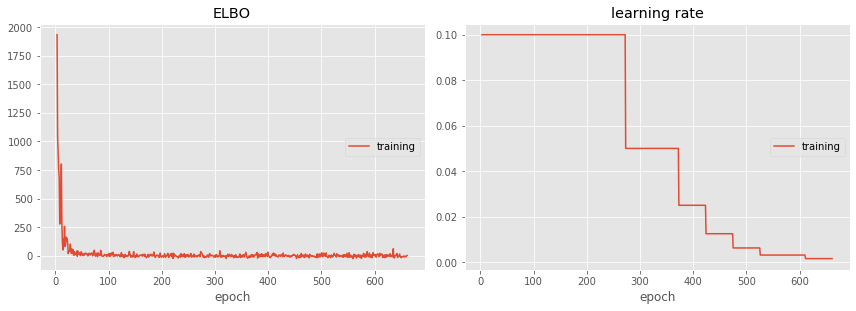

ELBO:
training   (min:  -24.981, max: 1932.480, cur:    2.595)

learning rate:
training   (min:    0.002, max:    0.100, cur:    0.002)


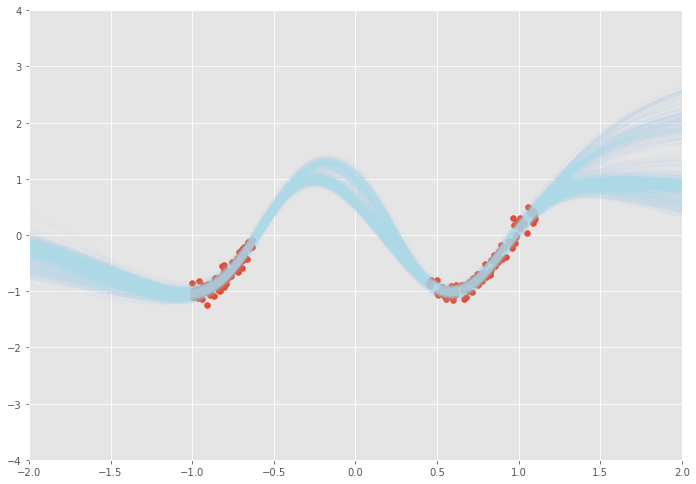

In [109]:
qC = Boost(qC, 10)
show_variational_posterior_predictive(qC)

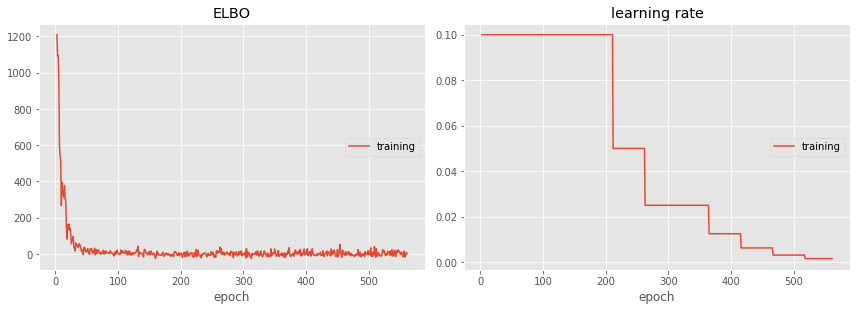

ELBO:
training   (min:  -26.281, max: 2489.315, cur:    0.444)

learning rate:
training   (min:    0.002, max:    0.100, cur:    0.002)


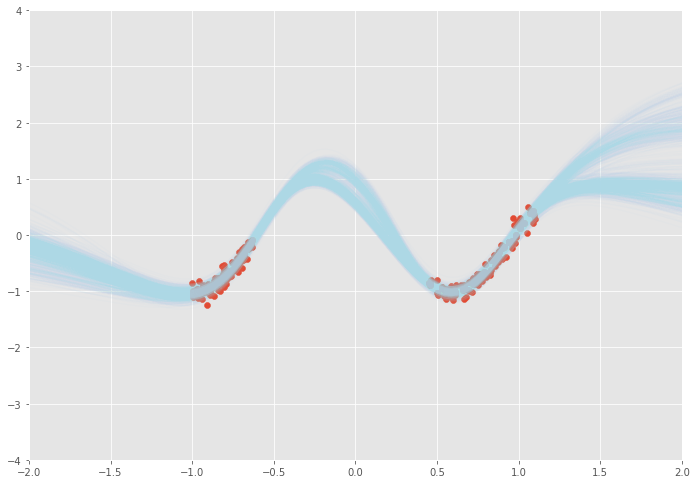

In [110]:
qC = Boost(qC, 10)
show_variational_posterior_predictive(qC)

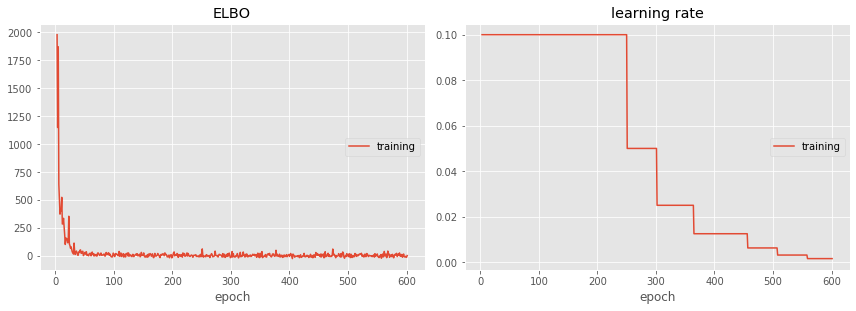

ELBO:
training   (min:  -26.292, max: 2595.149, cur:    0.831)

learning rate:
training   (min:    0.002, max:    0.100, cur:    0.002)


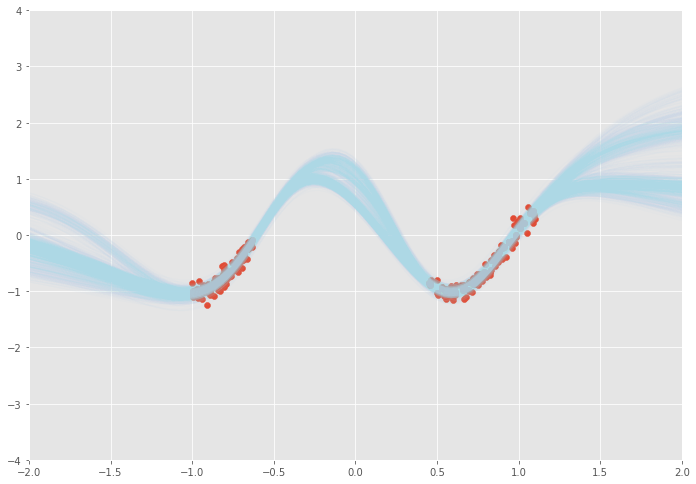

In [111]:
qC = Boost(qC, 10)
show_variational_posterior_predictive(qC)

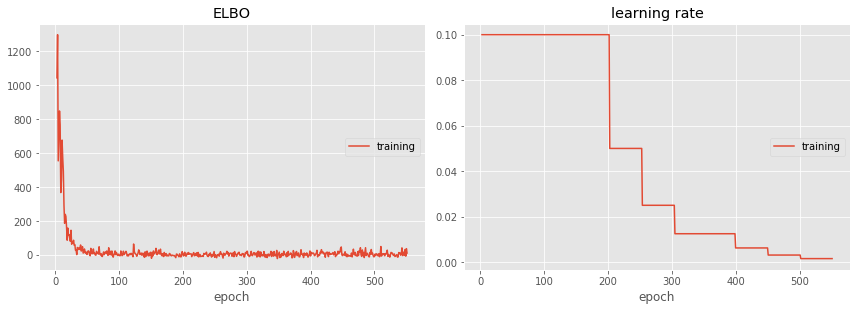

ELBO:
training   (min:  -23.244, max: 1760.826, cur:    9.262)

learning rate:
training   (min:    0.002, max:    0.100, cur:    0.002)


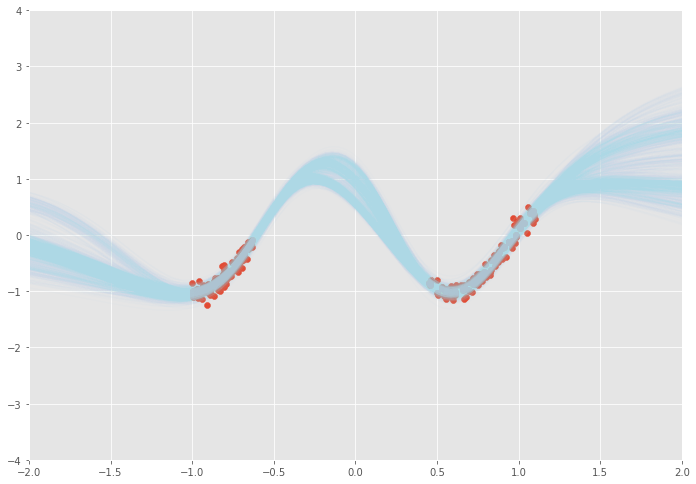

In [112]:
qC = Boost(qC, 10)
show_variational_posterior_predictive(qC)

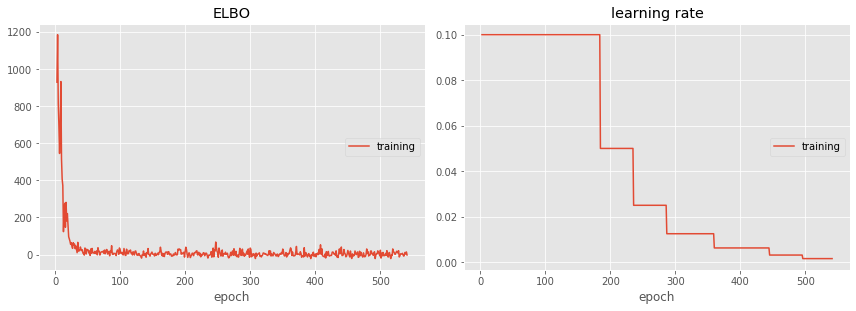

ELBO:
training   (min:  -21.173, max: 1785.067, cur:   -1.655)

learning rate:
training   (min:    0.002, max:    0.100, cur:    0.002)


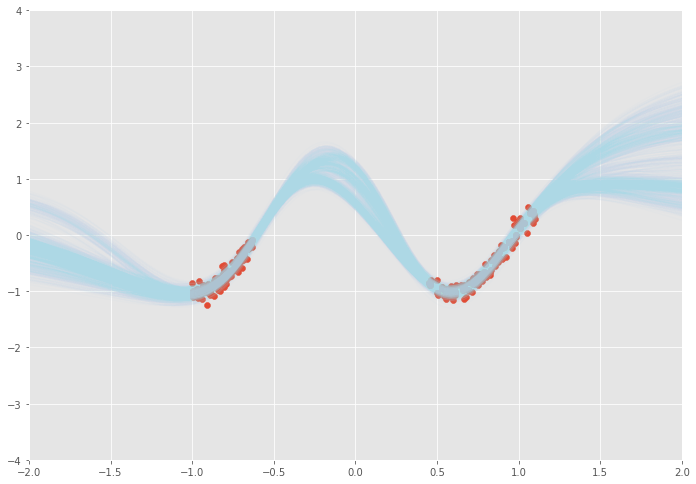

In [113]:
qC = Boost(qC, 10)
show_variational_posterior_predictive(qC)

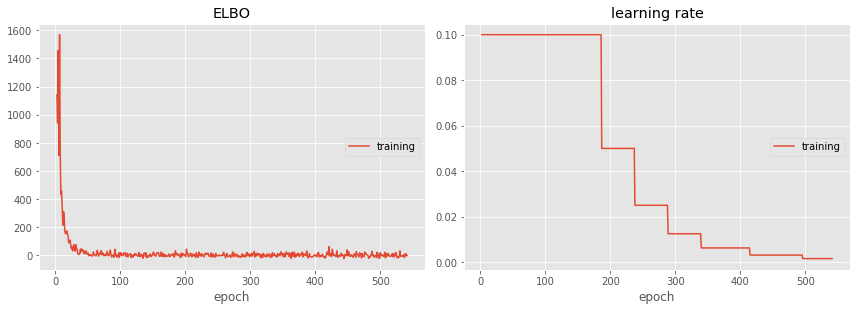

ELBO:
training   (min:  -22.200, max: 1890.038, cur:   -0.462)

learning rate:
training   (min:    0.002, max:    0.100, cur:    0.002)


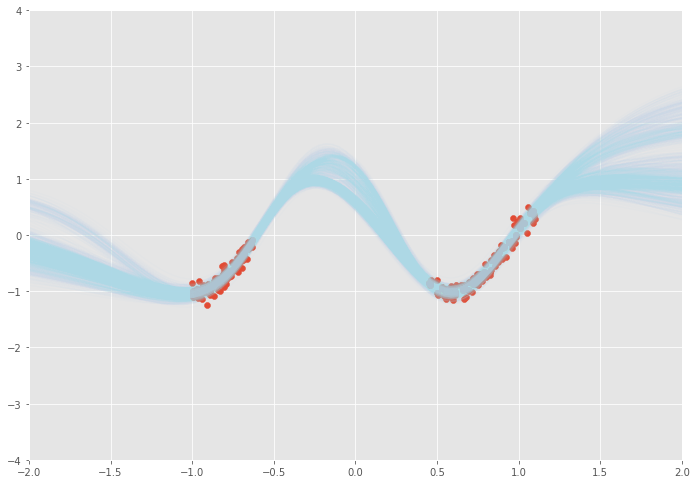

In [114]:
qC = Boost(qC, 10)
show_variational_posterior_predictive(qC)

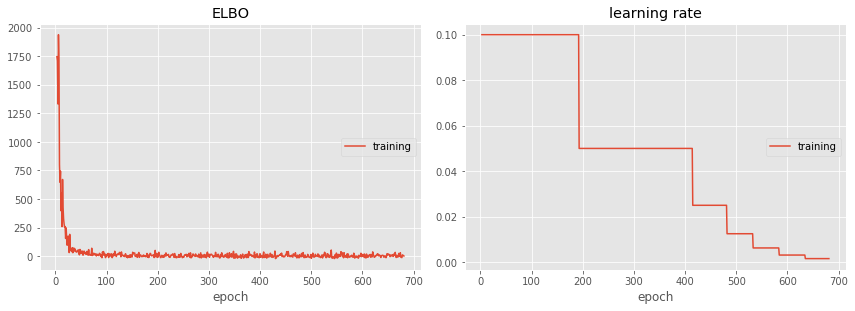

ELBO:
training   (min:  -21.086, max: 2659.612, cur:    1.624)

learning rate:
training   (min:    0.002, max:    0.100, cur:    0.002)


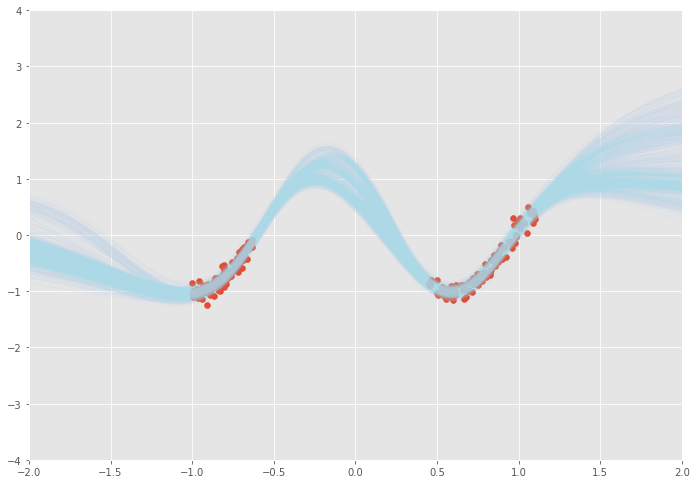

In [115]:
qC = Boost(qC, 10)
show_variational_posterior_predictive(qC)

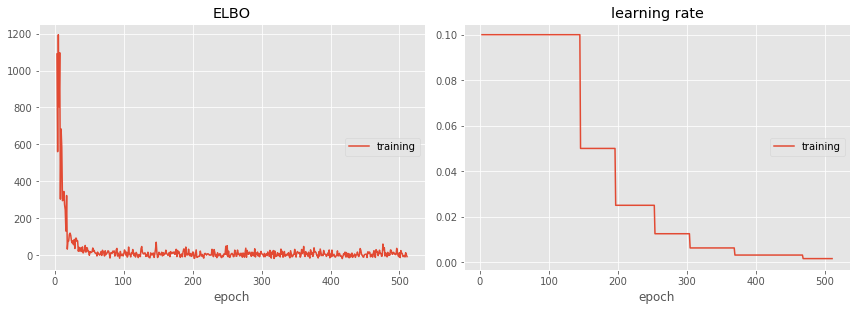

ELBO:
training   (min:  -19.276, max: 1657.529, cur:   -8.595)

learning rate:
training   (min:    0.002, max:    0.100, cur:    0.002)


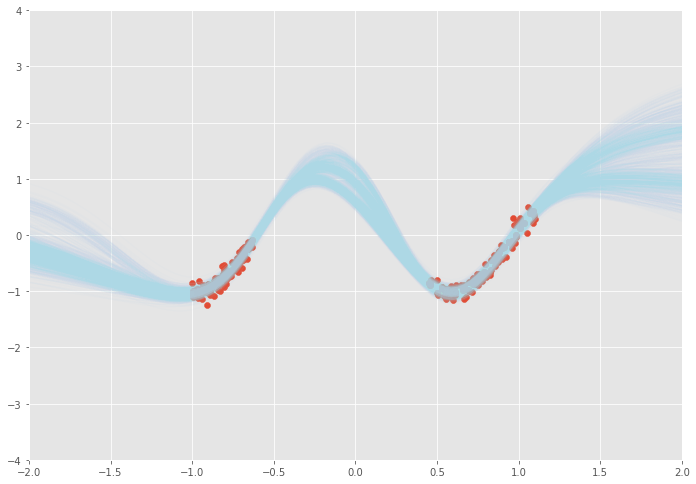

In [116]:
qC = Boost(qC, 10)
show_variational_posterior_predictive(qC)

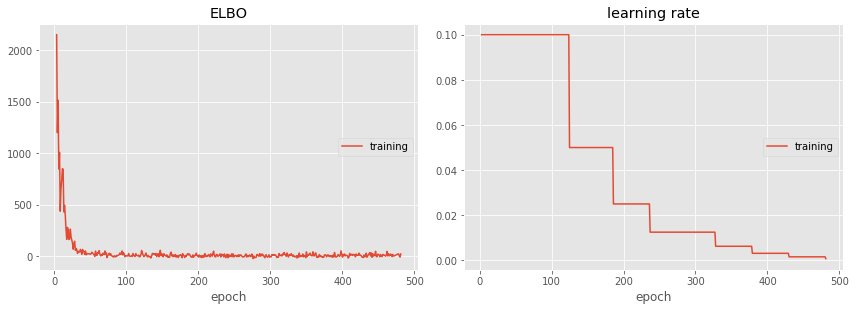

ELBO:
training   (min:  -22.927, max: 2341.935, cur:   21.702)

learning rate:
training   (min:    0.001, max:    0.100, cur:    0.001)


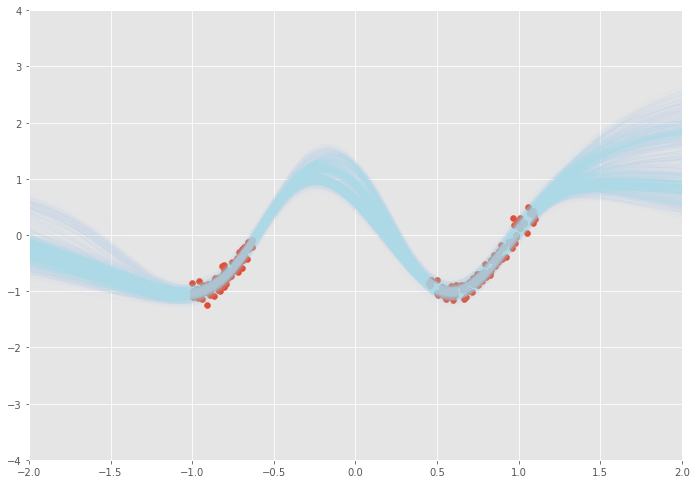

In [117]:
qC = Boost(qC, 10)
show_variational_posterior_predictive(qC)

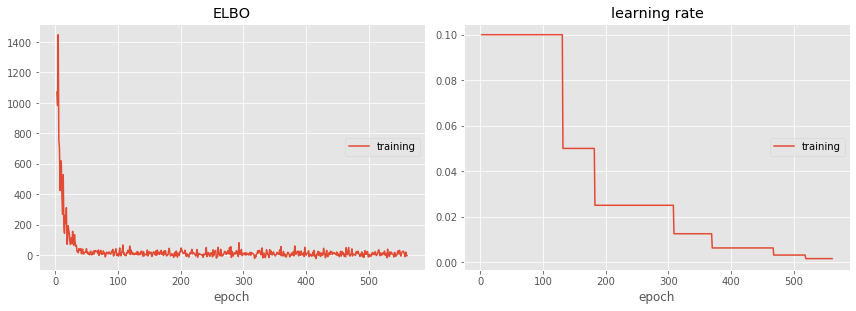

ELBO:
training   (min:  -23.605, max: 1693.379, cur:   -4.023)

learning rate:
training   (min:    0.002, max:    0.100, cur:    0.002)


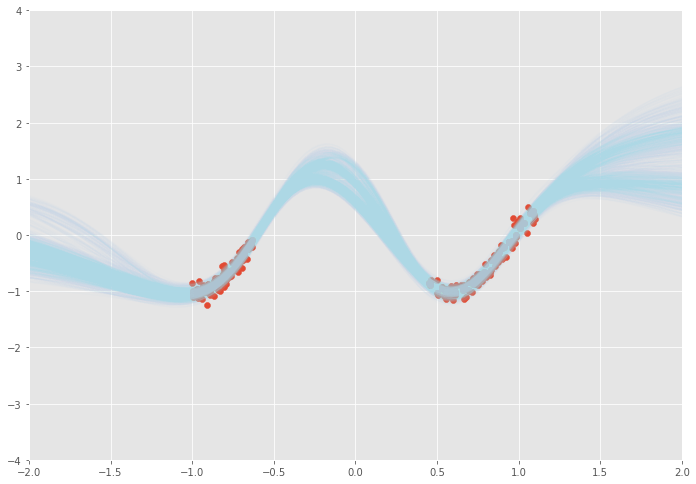

In [118]:
qC = Boost(qC, 10)
show_variational_posterior_predictive(qC)

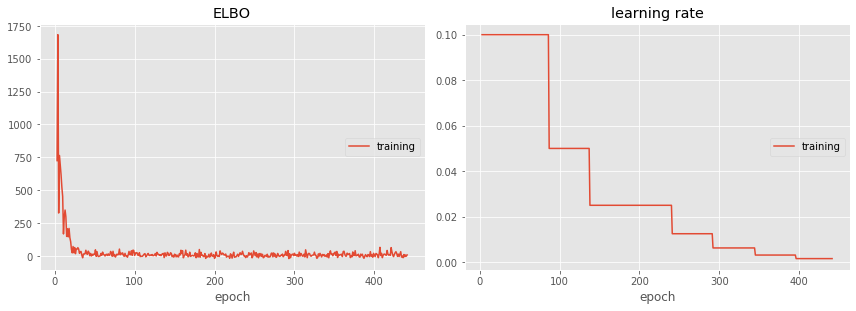

ELBO:
training   (min:  -19.929, max: 1682.686, cur:    8.071)

learning rate:
training   (min:    0.002, max:    0.100, cur:    0.002)


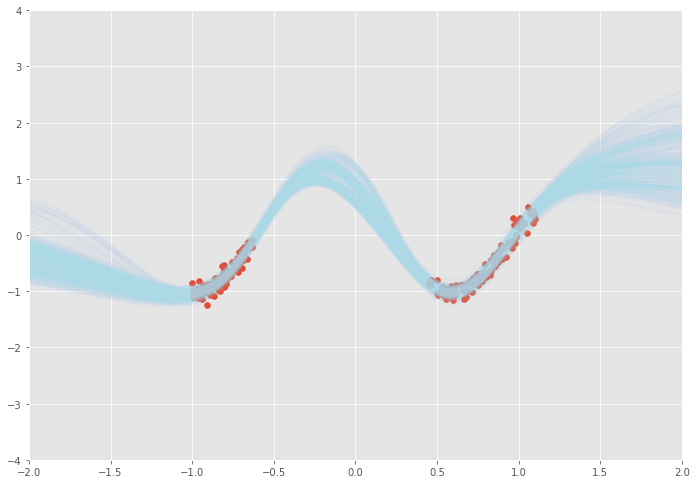

In [119]:
qC = Boost(qC, 10)
show_variational_posterior_predictive(qC)

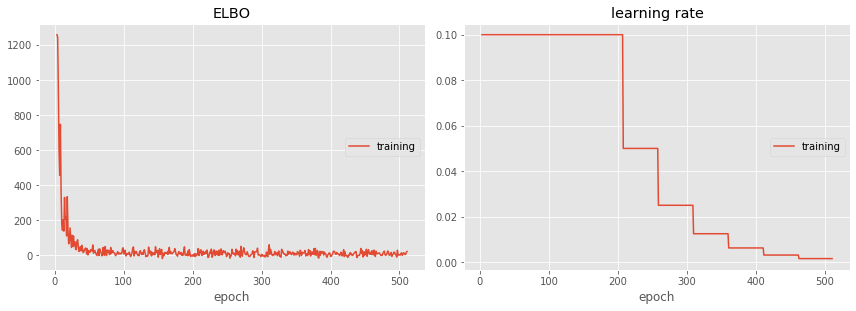

ELBO:
training   (min:  -21.094, max: 1837.205, cur:   19.341)

learning rate:
training   (min:    0.002, max:    0.100, cur:    0.002)


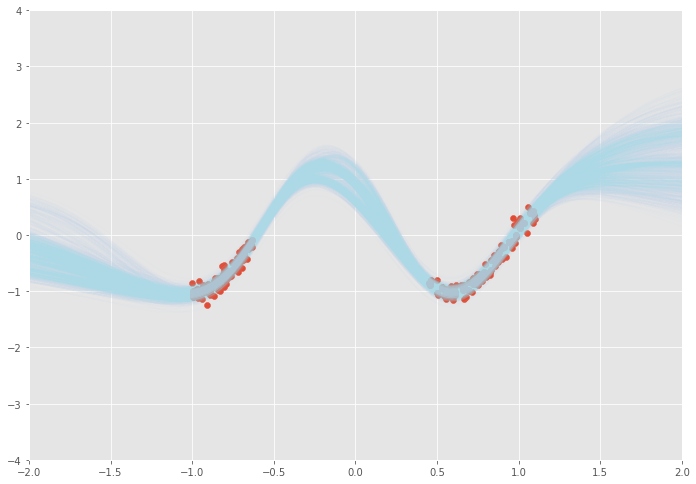

In [120]:
qC = Boost(qC, 10)
show_variational_posterior_predictive(qC)

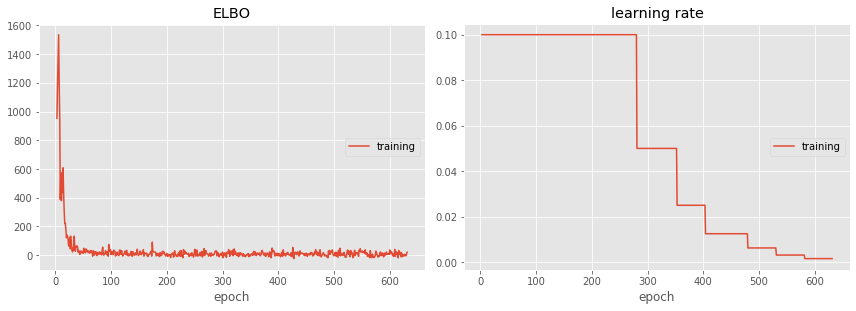

ELBO:
training   (min:  -24.199, max: 2831.757, cur:   20.724)

learning rate:
training   (min:    0.002, max:    0.100, cur:    0.002)


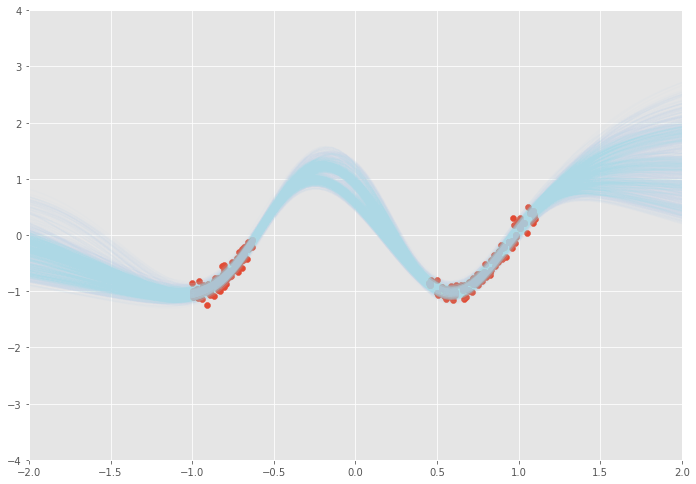

In [121]:
qC = Boost(qC, 10)
show_variational_posterior_predictive(qC)

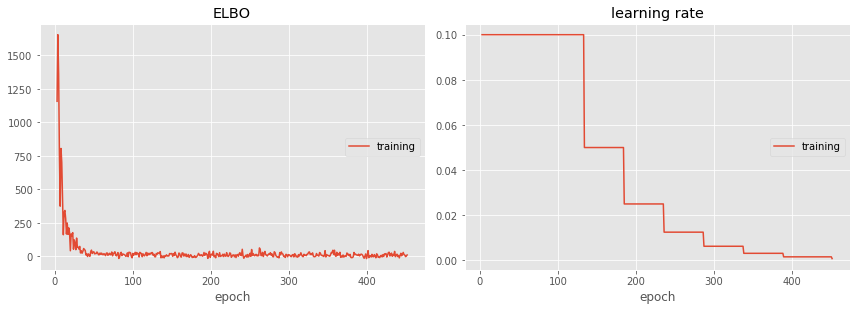

ELBO:
training   (min:  -16.492, max: 2124.928, cur:   10.776)

learning rate:
training   (min:    0.001, max:    0.100, cur:    0.001)


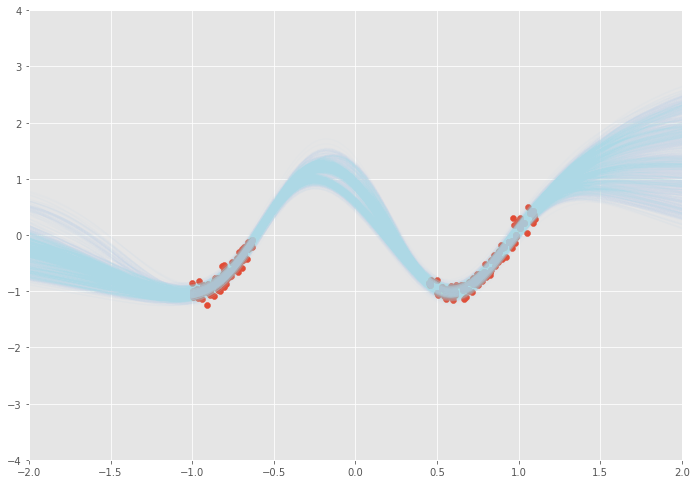

In [122]:
qC = Boost(qC, 10)
show_variational_posterior_predictive(qC)

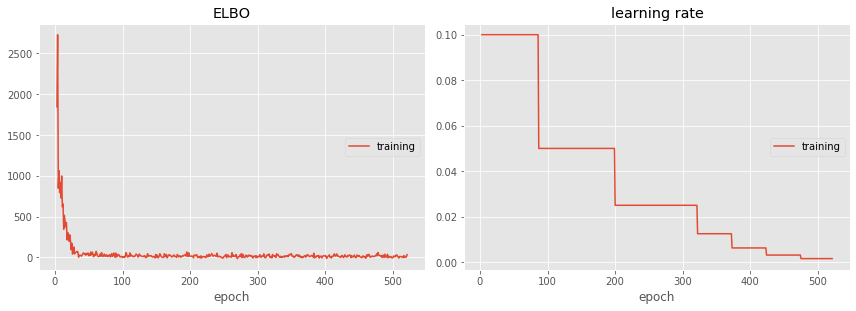

ELBO:
training   (min:  -15.638, max: 2818.646, cur:   33.369)

learning rate:
training   (min:    0.002, max:    0.100, cur:    0.002)


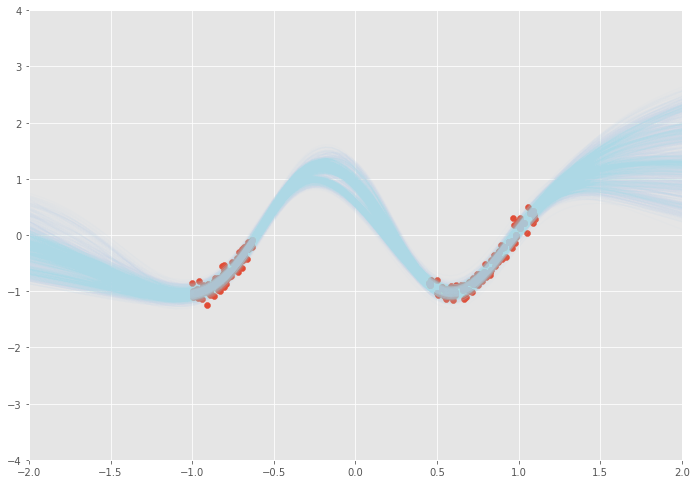

In [123]:
qC = Boost(qC, 10)
show_variational_posterior_predictive(qC)

In [124]:
qC.proportions

tensor([0.0100, 0.0016, 0.0049, 0.0222, 0.0016, 0.0033, 0.0035, 0.0069, 0.0070,
        0.0038, 0.0949, 0.0149, 0.0114, 0.0113, 0.0133, 0.0119, 0.0333, 0.0169,
        0.0228, 0.0635, 0.0141, 0.0487, 0.0435, 0.0442, 0.1541, 0.0733, 0.0679,
        0.1060, 0.0889], device='cuda:0')